### Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)#
import tensorflow as tf
import os
import random
import platform
import sys
import gc
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelBinarizer
import PIL
from PIL import Image
from IPython.display import SVG
from tensorflow import keras
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import plot_model

2023-11-26 12:12:07.019989: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-26 12:12:07.054927: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-26 12:12:07.634088: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Enable Cuda if OS is Windows

In [2]:
if platform.system() == 'Windows':
    device = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Set path and get all classes. ".DS_Store" needs to be removed on MacOS again

In [4]:
d = '/home/sebastian/Documents/Hauptprojekt/Daten_sorted/'
classes = (os.listdir(d))
print(os.device_encoding) 
if "._.DS_Store" in classes:
    classes.remove("._.DS_Store")
if ".DS_Store" in classes:
    classes.remove(".DS_Store")

<built-in function device_encoding>


In [5]:
print(classes)

['sales_order', 'purchase_order', 'utility_bill', 'debit_note', 'order', 'receipt', 'proforma', 'tax_invoice', 'credit_note']


### Global variables

In [6]:
img_size = 299
batch_size = 32
epochs = 50
mod_tax = 10
mod_order = 5
train_size = 0.7
val_size = 0.2
test_size = 0.1
seed = 4321
channels = 3
learning_rate = 0.00001

### Get all data

In [7]:
total_set = []
total_labels = []
counter_tax = 0 
counter_order = 0


for root, dirs, files in os.walk(d):
    for file in files:
        if file.endswith(".jpg"):
            label = root.split(os.path.sep)[-1]
            if label == "tax_invoice":
                counter_tax +=1
                if counter_tax % mod_tax == 0:
                    path = os.path.join(root, file)
                    total_set.append(path)
                    total_labels.append(label)
            elif label == "order":
                counter_order +=1
                if counter_order % mod_order == 0:
                    path = os.path.join(root, file)
                    total_set.append(path)
                    total_labels.append(label)
            else:    
                path = os.path.join(root, file)
                total_set.append(path)
                total_labels.append(label)
            

# Return image class based on list entry (path)         
def getClass(img):
    return img.split(os.path.sep)[-2]


print(total_set[0])
print('GetClass : ', getClass(total_set[0]))
print('Label : ', total_labels[0])

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/sales_order/synthetic-6a8be7d3aa8c44d6af9a2656-052(1).jpg
GetClass :  sales_order
Label :  sales_order


/home/sebastian/Documents/Hauptprojekt/Daten_sorted/tax_invoice/synthetic-60342157e5654d1292205df4-813(1).jpg


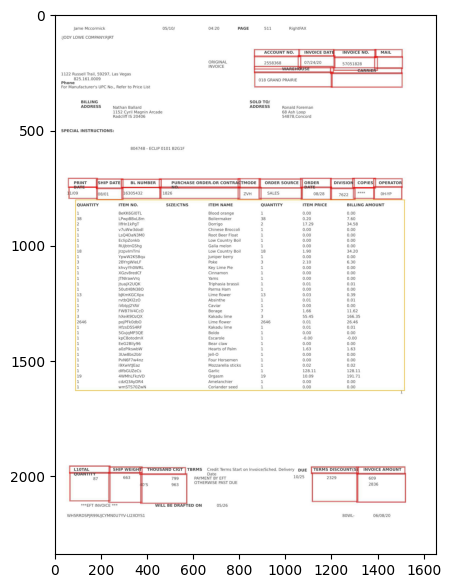

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/receipt/synthetic-410651d35003486c860e6985-120(1).jpg


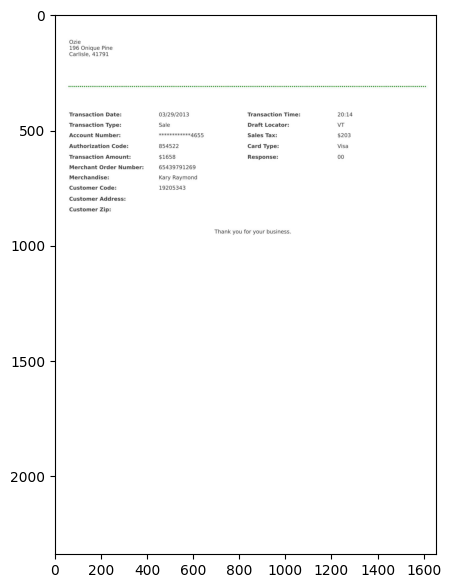

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/tax_invoice/synthetic-1c5cf2840ec745479b53bcad-958(1).jpg


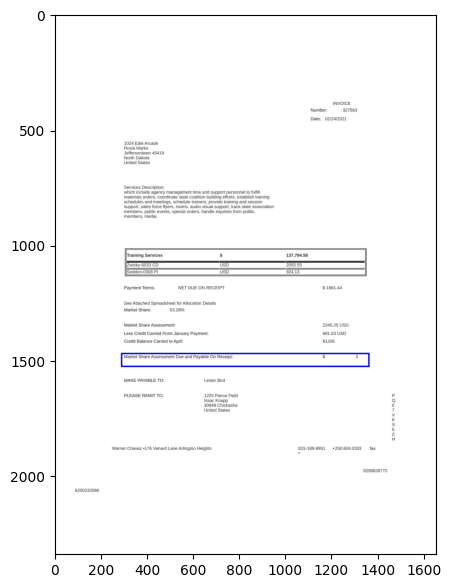

In [8]:
random.Random(seed).shuffle(total_set)

for ima in total_set[0:3] :
    print(ima)
    img = mpimg.imread(ima)
    plt.figure(figsize=(7,7))
    imgplot = plt.imshow(img, cmap="gray")
    plt.show()

### Sorting data in usable sets¶

In [9]:
# Get data and separate it in sets
total_len = len(total_set)
index = 0

train_set = []
train_label = []

val_set = []
val_label = []

test_set = []
test_label = []


for i in total_set[0: int(total_len*train_size)] :
    train_set.append(i)
    train_label.append(getClass(i))
    
index = int(total_len*train_size)+1
    
for i in total_set[index: int(index + total_len*val_size)] :
    val_set.append(i)
    val_label.append(getClass(i))
    
index = int(index + total_len*val_size)+1 

for i in total_set[index: total_len] :
    test_set.append(i)
    test_label.append(getClass(i))

print(val_set[200])
print(val_label[200])

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/tax_invoice/synthetic-8a30b38f74cf4752bb0d6d06-172(1).jpg
tax_invoice


### Visualize class distribution

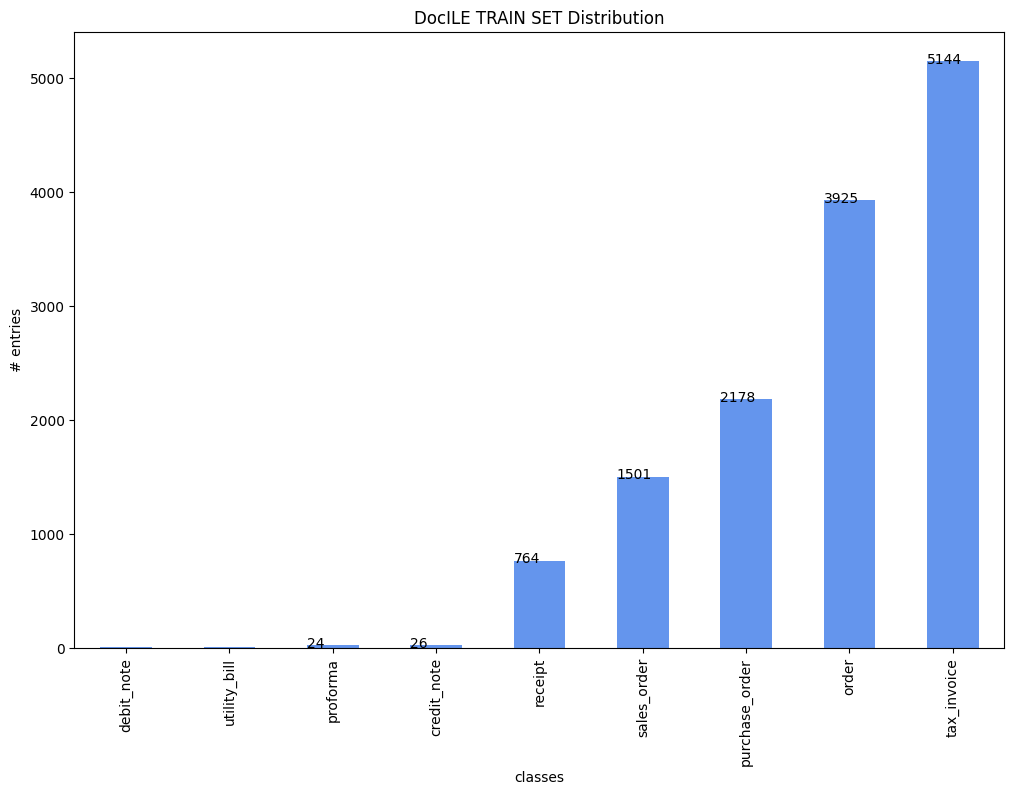

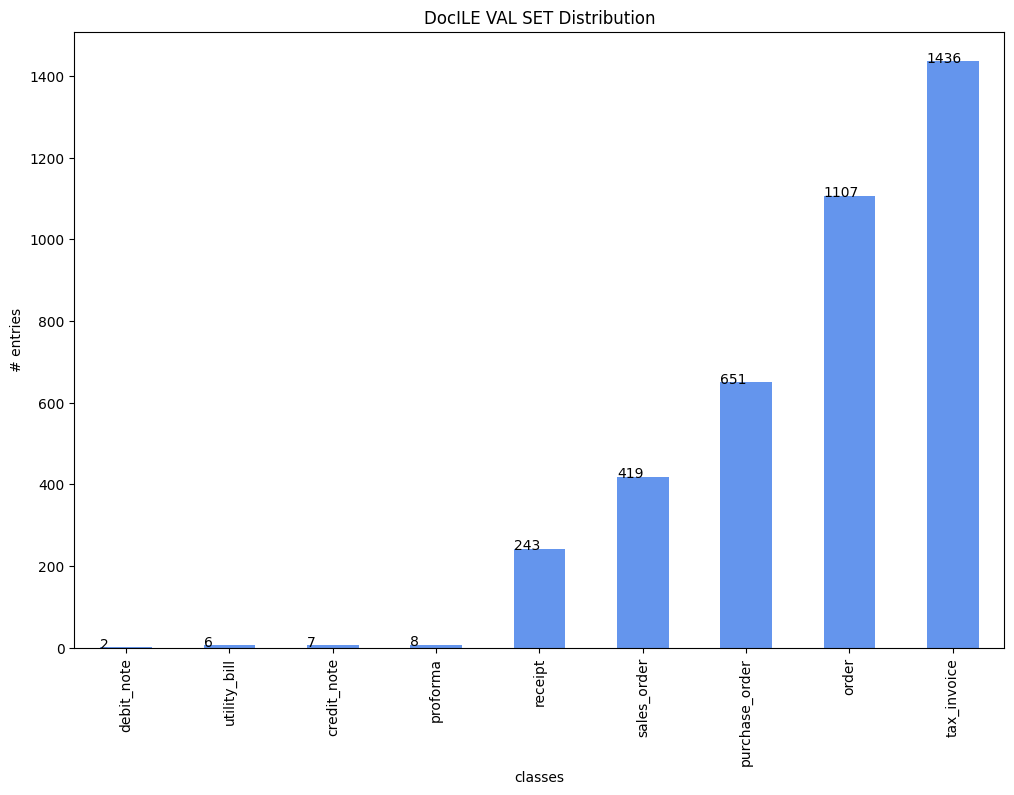

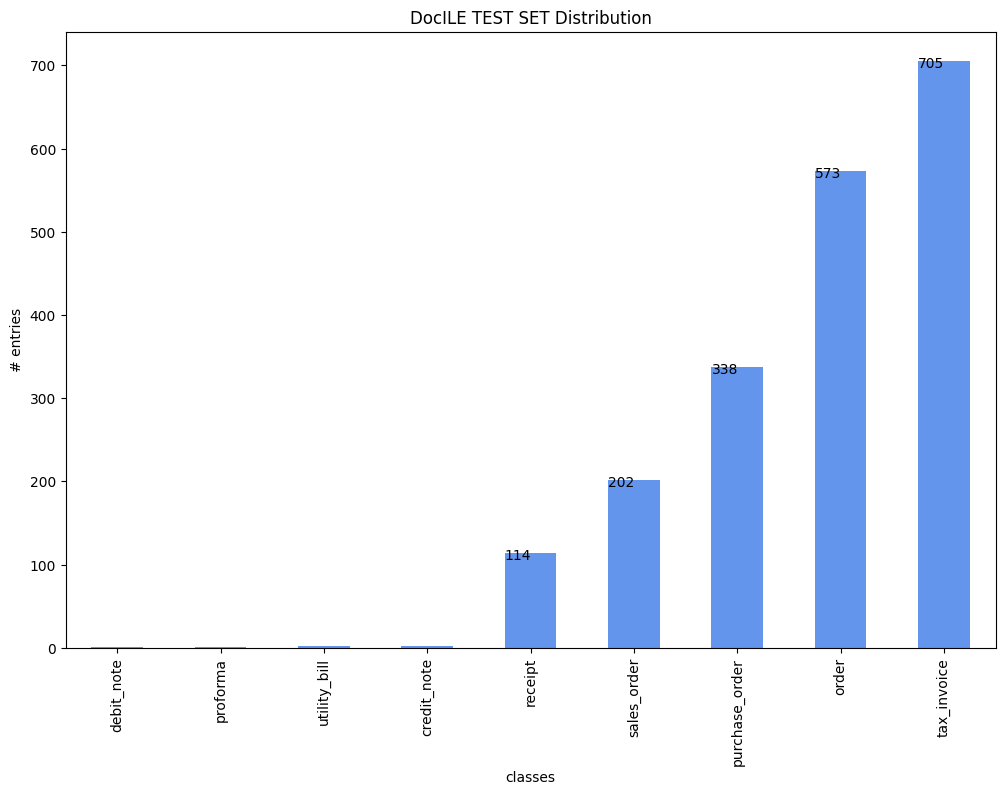

In [10]:
#################################################
# TRAIN SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in train_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('DocILE TRAIN SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-20))

#################################################
# VAL SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in val_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('DocILE VAL SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-3))
    
#################################################
# TEST SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in test_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('DocILE TEST SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-8))

### Preprocess data (resize and transform to Numpy array)

In [13]:
def process_images(img_set) : 
    processed_img = []

    for i in range(len(img_set)):
        processed_img.append(cv2.resize(cv2.imread(img_set[i], cv2.IMREAD_COLOR), (img_size, img_size)))
    
    return processed_img
    
x_train = process_images(train_set)

KeyboardInterrupt: 

In [19]:
def process_images(img_set) : 
    processed_img = []

    for i in range(len(img_set)):
        processed_img.append(cv2.resize(cv2.imread(img_set[i], cv2.IMREAD_COLOR), (img_size, img_size)))
   
    return processed_img
    
x_test = process_images(test_set)

In [20]:
def process_images(img_set) : 
    processed_img = []

    for i in range(len(img_set)):
        processed_img.append(cv2.resize(cv2.imread(img_set[i], cv2.IMREAD_COLOR), (img_size, img_size)))
    
    return processed_img
    
x_val = process_images(val_set)

Use LabelBinarizer. Documentation and functionality can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html

train shape :  (13576, 299, 299, 3)
(13576, 9)
test shape :  (1938, 299, 299, 3)
(1938, 9)
valdiation shape :  (3879, 299, 299, 3)
(3879, 9)
tax_invoice
[0 0 0 0 0 0 0 1 0]
['credit_note' 'debit_note' 'order' 'proforma' 'purchase_order' 'receipt'
 'sales_order' 'tax_invoice' 'utility_bill']


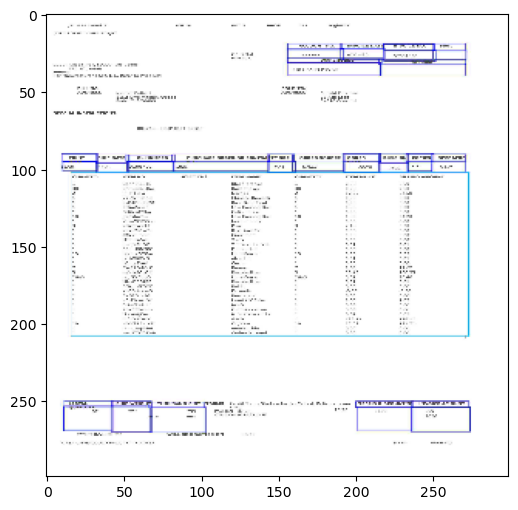

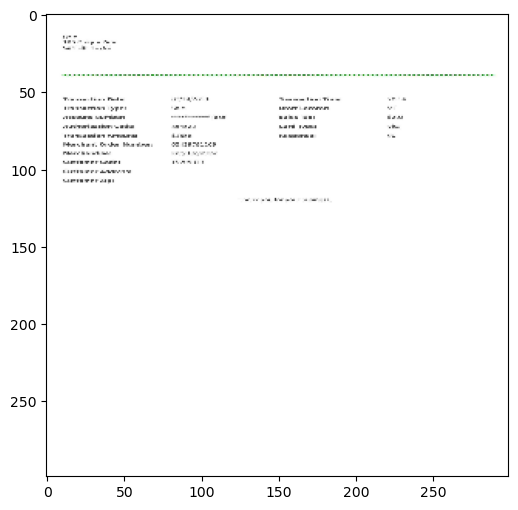

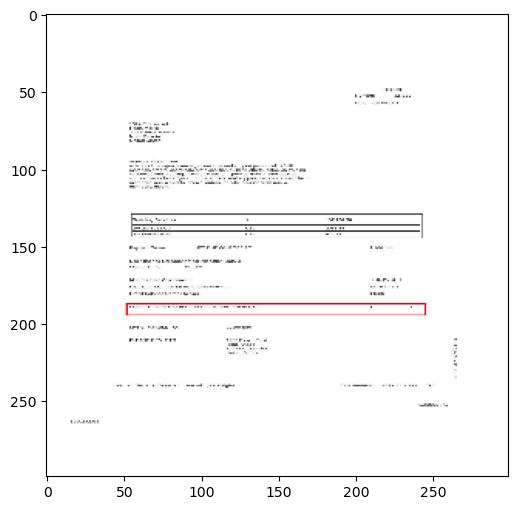

In [25]:
lb = LabelBinarizer()
lb.fit(list(classes))

x_train = np.array(x_train)
y_train =lb.transform(np.array(train_label))

x_test = np.array(x_test)
y_test = lb.transform(np.array(test_label))

x_val = np.array(x_val)
y_val = lb.transform(np.array(val_label))

print("train shape : ", x_train.shape)
print(y_train.shape)
print("test shape : ", x_test.shape)
print(y_test.shape)
print("valdiation shape : ", x_val.shape)
print(y_val.shape)


for i in range(3) :
    plt.figure(figsize=(6,6))
    imgplot = plt.imshow(x_train[i])

print(train_label[0])
print(y_train[0])
print(lb.classes_)

### Save the sets to .npy file for use after restarting runtime

In [22]:
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/x_train.npy', x_train)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/x_test.npy', x_test)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/y_train.npy', y_train)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/y_test.npy', y_test)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/x_val.npy', x_val)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/y_val.npy', y_val)

### load sets after restarting runtime

In [7]:
x_train = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/x_train.npy')
x_test = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/x_test.npy')
y_train = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/y_train.npy')
y_test = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/y_test.npy')
x_val = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/x_val.npy')
y_val = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/y_val.npy')

In [8]:
len(x_train)

13576

In [83]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


Creating model (pretrained CNN) InceptionV3

In [89]:
base_model = InceptionV3(weights = "imagenet", include_top=False, input_shape = (img_size, img_size, channels))

for layer in base_model.layers:
    layer.trainable = False

if layer.trainable == False:
    name_layer = "_added_layer_"
elif layer.trainable == True:
    name_layer = "_all_layer_"
    
print(name_layer)
    
base_model.summary()

_added_layer_
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 149, 149, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 149, 149, 32)         0         ['bat

                                                                                                  
 conv2d_105 (Conv2D)         (None, 35, 35, 32)           6144      ['average_pooling2d_9[0][0]'] 
                                                                                                  
 batch_normalization_99 (Ba  (None, 35, 35, 64)           192       ['conv2d_99[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_101 (B  (None, 35, 35, 64)           192       ['conv2d_101[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_104 (B  (None, 35, 35, 96)           288       ['conv2d_104[0][0]']          
 atchNorma

 )                                                                  ]']                           
                                                                                                  
 activation_111 (Activation  (None, 35, 35, 96)           0         ['batch_normalization_111[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_112 (Activation  (None, 35, 35, 64)           0         ['batch_normalization_112[0][0
 )                                                                  ]']                           
                                                                                                  
 mixed1 (Concatenate)        (None, 35, 35, 288)          0         ['activation_106[0][0]',      
                                                                     'activation_108[0][0]',      
          

 )                                                                  ]']                           
                                                                                                  
 conv2d_122 (Conv2D)         (None, 35, 35, 96)           55296     ['activation_121[0][0]']      
                                                                                                  
 batch_normalization_122 (B  (None, 35, 35, 96)           288       ['conv2d_122[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_122 (Activation  (None, 35, 35, 96)           0         ['batch_normalization_122[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_12

                                                                                                  
 conv2d_124 (Conv2D)         (None, 17, 17, 192)          147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_127 (Conv2D)         (None, 17, 17, 192)          172032    ['activation_126[0][0]']      
                                                                                                  
 conv2d_132 (Conv2D)         (None, 17, 17, 192)          172032    ['activation_131[0][0]']      
                                                                                                  
 conv2d_133 (Conv2D)         (None, 17, 17, 192)          147456    ['average_pooling2d_12[0][0]']
                                                                                                  
 batch_normalization_124 (B  (None, 17, 17, 192)          576       ['conv2d_124[0][0]']          
 atchNorma

 activation_141 (Activation  (None, 17, 17, 160)          0         ['batch_normalization_141[0][0
 )                                                                  ]']                           
                                                                                                  
 average_pooling2d_13 (Aver  (None, 17, 17, 768)          0         ['mixed4[0][0]']              
 agePooling2D)                                                                                    
                                                                                                  
 conv2d_134 (Conv2D)         (None, 17, 17, 192)          147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_137 (Conv2D)         (None, 17, 17, 192)          215040    ['activation_136[0][0]']      
                                                                                                  
 conv2d_14

 atchNormalization)                                                                               
                                                                                                  
 activation_146 (Activation  (None, 17, 17, 160)          0         ['batch_normalization_146[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_151 (Activation  (None, 17, 17, 160)          0         ['batch_normalization_151[0][0
 )                                                                  ]']                           
                                                                                                  
 average_pooling2d_14 (Aver  (None, 17, 17, 768)          0         ['mixed5[0][0]']              
 agePooling2D)                                                                                    
          

                                                                                                  
 batch_normalization_156 (B  (None, 17, 17, 192)          576       ['conv2d_156[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_161 (B  (None, 17, 17, 192)          576       ['conv2d_161[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_156 (Activation  (None, 17, 17, 192)          0         ['batch_normalization_156[0][0
 )                                                                  ]']                           
                                                                                                  
 activatio

 )                                                                  ]']                           
                                                                                                  
 conv2d_165 (Conv2D)         (None, 8, 8, 320)            552960    ['activation_164[0][0]']      
                                                                                                  
 conv2d_169 (Conv2D)         (None, 8, 8, 192)            331776    ['activation_168[0][0]']      
                                                                                                  
 batch_normalization_165 (B  (None, 8, 8, 320)            960       ['conv2d_165[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_169 (B  (None, 8, 8, 192)            576       ['conv2d_169[0][0]']          
 atchNorma

 )                                                                  ]']                           
                                                                                                  
 activation_176 (Activation  (None, 8, 8, 384)            0         ['batch_normalization_176[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_177 (Activation  (None, 8, 8, 384)            0         ['batch_normalization_177[0][0
 )                                                                  ]']                           
                                                                                                  
 batch_normalization_178 (B  (None, 8, 8, 192)            576       ['conv2d_178[0][0]']          
 atchNormalization)                                                                               
          

 )                                                                  ]']                           
                                                                                                  
 activation_182 (Activation  (None, 8, 8, 384)            0         ['batch_normalization_182[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_185 (Activation  (None, 8, 8, 384)            0         ['batch_normalization_185[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_186 (Activation  (None, 8, 8, 384)            0         ['batch_normalization_186[0][0
 )                                                                  ]']                           
          

### finetune model

In [90]:
print(layer.trainable)

False


In [91]:
model = models.Sequential()

model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu',  name='dense'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(classes), activation='softmax',  name='predictions'))

model.summary()

print('Number of trainable weights : ', len(model.trainable_weights))

plot_model(model, to_file='model_InceptionV3.png')
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 128)               16777344  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 predictions (Dense)         (None, 9)                 1161      
                                                                 
Total params: 38581289 (147.18 MB)
Trainable params: 16778505 (64.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
Numbe

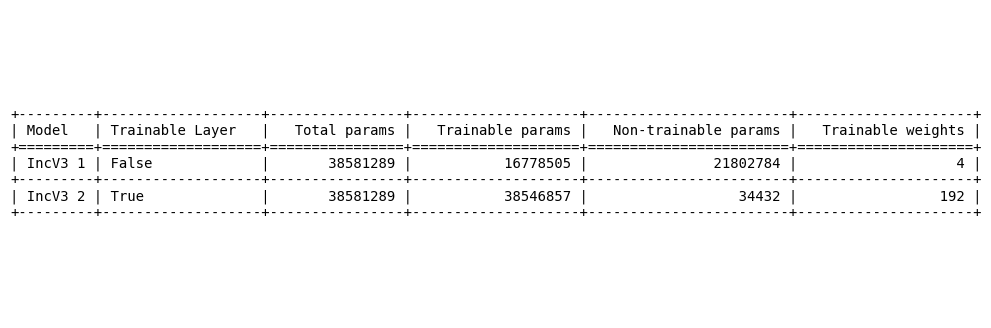

In [92]:
from tabulate import tabulate
from PIL import Image, ImageDraw, ImageFont

# Model information
model1_info = {
    "Model": "IncV3 1",
    "trainable layers": "False",
    "Total params": 38581289,
    "Trainable params": 16778505,
    "Non-trainable params": 21802784,
    "Number of trainable weights": 4
}

model2_info = {
    "Model": "IncV3 2",
    "trainable layers": "True",
    "Total params": 38581289,
    "Trainable params": 38546857,
    "Non-trainable params": 34432,
    "Number of trainable weights": 192
}

# Organize model information
models_data = [
    [model1_info["Model"], model1_info["trainable layers"], model1_info["Total params"], model1_info["Trainable params"], model1_info["Non-trainable params"], model1_info["Number of trainable weights"]],
    [model2_info["Model"], model2_info["trainable layers"], model2_info["Total params"], model2_info["Trainable params"], model2_info["Non-trainable params"], model2_info["Number of trainable weights"]]
]

# Table headers
headers = ["Model", "Trainable Layer", "Total params", "Trainable params", "Non-trainable params", "Trainable weights"]

# Create and print the table
table = tabulate(models_data, headers, tablefmt="grid")

# Create a figure and axis with matplotlib
fig, ax = plt.subplots(figsize=(8, 4))

# Remove the axes
ax.axis("off")

# Display the table text on the axis
ax.text(0.5, 0.5, table, va="center", ha="center", fontsize=10, fontfamily="monospace")

# Save the figure as an image
plt.savefig("/home/sebastian/Documents/Hauptprojekt/Models/InceptionV3/IncV3_table.png", bbox_inches="tight", dpi=300)

In [93]:
model.compile(optimizer=optimizers.legacy.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

train_model = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_val, y_val))

Epoch 1/5
425/425 [==============================] - 23s 48ms/step - loss: 2.8488 - accuracy: 0.4277 - val_loss: 0.9724 - val_accuracy: 0.6179
Epoch 2/5
425/425 [==============================] - 19s 44ms/step - loss: 1.3390 - accuracy: 0.5257 - val_loss: 0.7582 - val_accuracy: 0.7309
Epoch 3/5
425/425 [==============================] - 18s 43ms/step - loss: 1.0889 - accuracy: 0.5969 - val_loss: 0.6069 - val_accuracy: 0.7827
Epoch 4/5
 25/425 [>.............................] - ETA: 13s - loss: 1.0487 - accuracy: 0.5975

KeyboardInterrupt: 

save Model

In [15]:
#model.save('/home/sebastian/Documents/Hauptprojekt/Models/InceptionV3/trained_model' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.h5')

/home/sebastian/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Plot training accuracy and loss

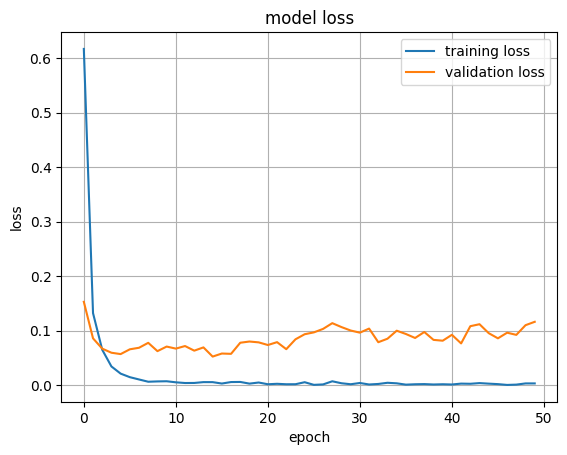

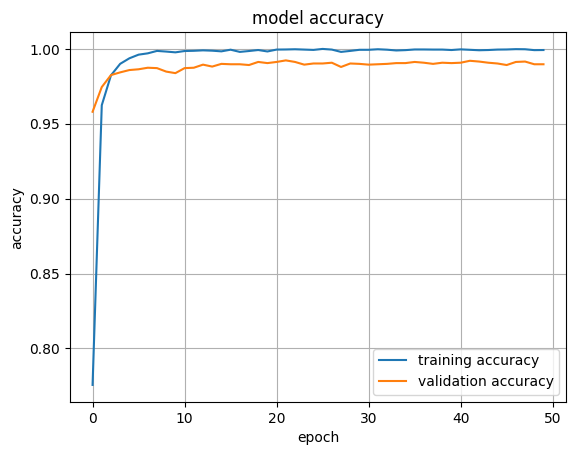

In [16]:
plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/ImageClassification/InceptionV3/model_loss' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.png')
plt.show()

plt.plot(train_model.history['accuracy'])
plt.plot(train_model.history['val_accuracy'])
plt.title('model accuracy')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'], loc='lower right')
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/ImageClassification/InceptionV3/model_acc' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.png')
plt.show()

### Plot prediction accuracy

In [17]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

61/61 [==============================] - 3s 44ms/step - loss: 0.0796 - accuracy: 0.9917
Test loss: 0.07958782464265823
Test accuracy: 0.9917440414428711


In [18]:
with open("/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/IncV3_acc_dict.pkl", "rb") as file:
    IncV3_acc_dict = pickle.load(file)
with open("/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/IncV3_loss_dict.pkl", "rb") as file:
    IncV3_loss_dict = pickle.load(file)

In [19]:
IncV3_acc_dict['IncV3_acc' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order)] = score[1]
IncV3_loss_dict['IncV3_loss' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order)] = score[0]

In [20]:
with open("/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/IncV3_acc_dict.pkl", 'wb') as file:
    pickle.dump(IncV3_acc_dict, file)

with open("/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/IncV3_loss_dict.pkl", 'wb') as file:
    pickle.dump(IncV3_loss_dict, file)

In [8]:
lb = LabelBinarizer()
lb.fit(list(classes))

LabelBinarizer()

In [9]:
y_test = np.argmax(y_test,axis=1)
y_test_names = lb.classes_[y_test]

In [177]:
epochs = 30
name_layer = "_added_layer_"
#name_layer = "_all_layer_"

In [178]:
from keras.models import load_model
model = load_model('/home/sebastian/Documents/Hauptprojekt/Models/InceptionV3/trained_model' + str(name_layer) + str(epochs) + 'epochs_10_5.h5')

Use Model on test set

In [179]:
false_pred = []
true_pred = []

predictions=model.predict(x_test) 
predictions_list = predictions.tolist()
predicted_classes=np.argmax(predictions,axis=1)


count_true = 0
count_false = 0

for i, prediction in enumerate(predictions_list):
    state = True
    if (lb.classes_[predicted_classes[i]] != lb.classes_[y_test[i]]) :
        state = False
        count_false += 1
        false_pred.append(lb.classes_[y_test[i]])
    else :
        true_pred.append(lb.classes_[y_test[i]])
        count_true += 1
    
    print("Prediction : ", lb.classes_[predicted_classes[i]], "   |   Real class : ", lb.classes_[y_test[i]],  "   |   Result : ", state)

print("\nNumber of success : ", count_true) 
print("Number of error : ", count_false) 
print("Error rate : ", count_true/len(y_test))

61/61 [==============================] - 3s 28ms/step
Prediction :  tax_invoice    |   Real class :  tax_invoice    |   Result :  True
Prediction :  order    |   Real class :  order    |   Result :  True
Prediction :  order    |   Real class :  order    |   Result :  True
Prediction :  tax_invoice    |   Real class :  tax_invoice    |   Result :  True
Prediction :  order    |   Real class :  order    |   Result :  True
Prediction :  receipt    |   Real class :  receipt    |   Result :  True
Prediction :  order    |   Real class :  order    |   Result :  True
Prediction :  order    |   Real class :  order    |   Result :  True
Prediction :  order    |   Real class :  order    |   Result :  True
Prediction :  tax_invoice    |   Real class :  tax_invoice    |   Result :  True
Prediction :  tax_invoice    |   Real class :  tax_invoice    |   Result :  True
Prediction :  tax_invoice    |   Real class :  tax_invoice    |   Result :  True
Prediction :  purchase_order    |   Real class :  purc

Print wrong classifications per class

In [180]:
print(f'"debit_note" was classified wrong {false_pred.count("debit_note")} time(s) out of {false_pred.count("debit_note") + true_pred.count("debit_note")} time(s)')
print(f'"proforma" was classified wrong {false_pred.count("proforma")} time(s) out of {false_pred.count("proforma") + true_pred.count("proforma")} time(s)')
print(f'"utility_bill" was classified wrong {false_pred.count("utility_bill")} time(s) out of {false_pred.count("utility_bill") + true_pred.count("utility_bill")} time(s)')
print(f'"credit_note" was classified wrong {false_pred.count("credit_note")} time(s) out of {false_pred.count("credit_note") + true_pred.count("credit_note")} time(s)')
print(f'"receipt" was classified wrong {false_pred.count("receipt")} time(s) out of {false_pred.count("receipt") + true_pred.count("receipt")} time(s)')
print(f'"sales_order" was classified wrong {false_pred.count("sales_order")} time(s) out of {false_pred.count("sales_order") + true_pred.count("sales_order")} time(s)')
print(f'"purchase_order" was classified wrong {false_pred.count("purchase_order")} time(s) out of {false_pred.count("purchase_order") + true_pred.count("purchase_order")} time(s)')
print(f'"order" was classified wrong {false_pred.count("order")} time(s) out of {false_pred.count("order") + true_pred.count("order")} time(s)')
print(f'"tax_invoice" was classified wrong {false_pred.count("tax_invoice")} time(s) out of {false_pred.count("tax_invoice") + true_pred.count("tax_invoice")} time(s)')

"debit_note" was classified wrong 1 time(s) out of 1 time(s)
"proforma" was classified wrong 1 time(s) out of 1 time(s)
"utility_bill" was classified wrong 2 time(s) out of 2 time(s)
"credit_note" was classified wrong 2 time(s) out of 2 time(s)
"receipt" was classified wrong 13 time(s) out of 114 time(s)
"sales_order" was classified wrong 5 time(s) out of 202 time(s)
"purchase_order" was classified wrong 4 time(s) out of 338 time(s)
"order" was classified wrong 54 time(s) out of 573 time(s)
"tax_invoice" was classified wrong 15 time(s) out of 705 time(s)


In [181]:
predicted_classes_names = lb.classes_[predicted_classes]
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/predictions' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.npy', predicted_classes_names)

In [182]:
predicted_classes_names = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/predictions' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.npy')

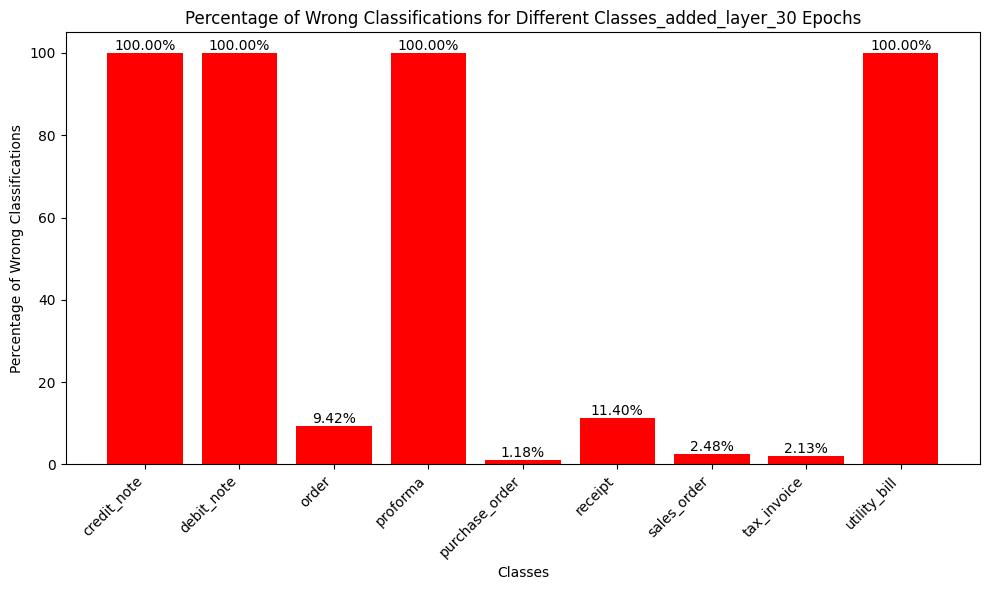

In [183]:
import matplotlib.pyplot as plt

# Data
categories = [
    "credit_note",
    "debit_note",
    "order",
    "proforma",
    "purchase_order",
    "receipt",
    "sales_order",
    "tax_invoice",
    "utility_bill"
]

wrong_counts = [
    false_pred.count("credit_note"),  # credit_note
    false_pred.count("debit_note"),  # debit_note
    false_pred.count("order"), # order
    false_pred.count("proforma"),  # proforma
    false_pred.count("purchase_order"),  # purchase_order
    false_pred.count("receipt"), # receipt
    false_pred.count("sales_order"),  # sales_order
    false_pred.count("tax_invoice"),  # tax_invoice
    false_pred.count("utility_bill")  # utility_bill
]

total_counts = [
    false_pred.count("credit_note") + true_pred.count("credit_note"),   # credit_note
    false_pred.count("debit_note") + true_pred.count("debit_note"),   # debit_note
    false_pred.count("order") + true_pred.count("order"), # order
    false_pred.count("proforma") + true_pred.count("proforma"),   # proforma
    false_pred.count("purchase_order") + true_pred.count("purchase_order"), # purchase_order
    false_pred.count("receipt") + true_pred.count("receipt"),  # receipt
    false_pred.count("sales_order") + true_pred.count("sales_order"), # sales_order
    false_pred.count("tax_invoice") + true_pred.count("tax_invoice"),  # tax_invoice
    false_pred.count("utility_bill") + true_pred.count("utility_bill")   # utility_bill
]


# Calculate percentage of wrong classifications
wrong_percentages = [wrong / total * 100 for wrong, total in zip(wrong_counts, total_counts)]

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, wrong_percentages, color='red')
plt.xlabel('Classes')
plt.ylabel('Percentage of Wrong Classifications')
plt.title('Percentage of Wrong Classifications for Different Classes'+ str(name_layer) + str(epochs) + ' Epochs')
plt.xticks(rotation=45, ha='right')

# Add numbers to the bars
for bar, wrong_percentage in zip(bars, wrong_percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{wrong_percentage:.2f}%',
        ha='center',
        va='bottom',
        color='black',
        fontsize=10
    )

plt.tight_layout()
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/ImageClassification/InceptionV3/WrongClassification' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.png', bbox_inches="tight")
plt.show()

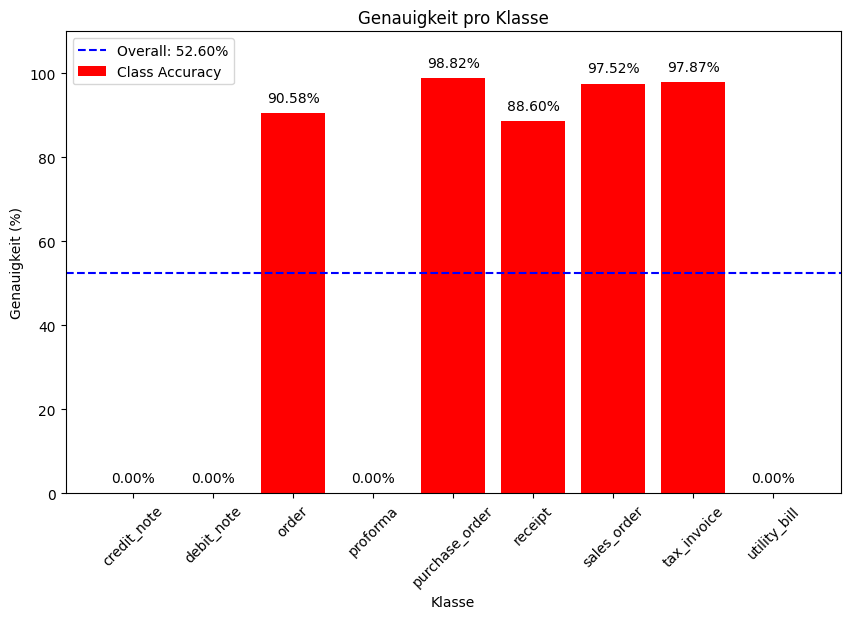

In [184]:
# Calculate the accuracy for each class
unique_classes = np.unique(y_test_names)
class_accuracies = []

for cls in unique_classes:
    correct_predictions = np.sum((y_test_names == cls) & (predicted_classes_names == cls))
    total_samples = np.sum(y_test_names == cls)
    
    # Check for potential division by zero errors
    if total_samples == 0:
        accuracy = 0.0
    else:
        accuracy = correct_predictions / total_samples
    
    class_accuracies.append(accuracy)

# Convert accuracies to percentages
class_percentages = [accuracy * 100 for accuracy in class_accuracies]

# Calculate the mean accuracy
mean_accuracy = np.mean(class_accuracies) * 100

# Create a bar plot with both class accuracies and mean accuracy
plt.figure(figsize=(10, 6))
bars = plt.bar(unique_classes, class_percentages, color='red', label='Class Accuracy')
plt.axhline(mean_accuracy, color='blue', linestyle='--', label=f'Overall: {(mean_accuracy/100):.2%}')

plt.xlabel('Klasse')
plt.ylabel('Genauigkeit (%)')
plt.title('Genauigkeit pro Klasse')
plt.ylim(0, 110)  # Set the y-axis limits to 0-100 for percentages
plt.xticks(rotation=45)

# Add percentage labels above each bar
for bar, percentage in zip(bars, class_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2, f'{percentage:.2f}%', ha='center', va='bottom')


# Add a legend
plt.legend()

plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/ImageClassification/InceptionV3/Accuracy' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.png', bbox_inches="tight")
plt.show()

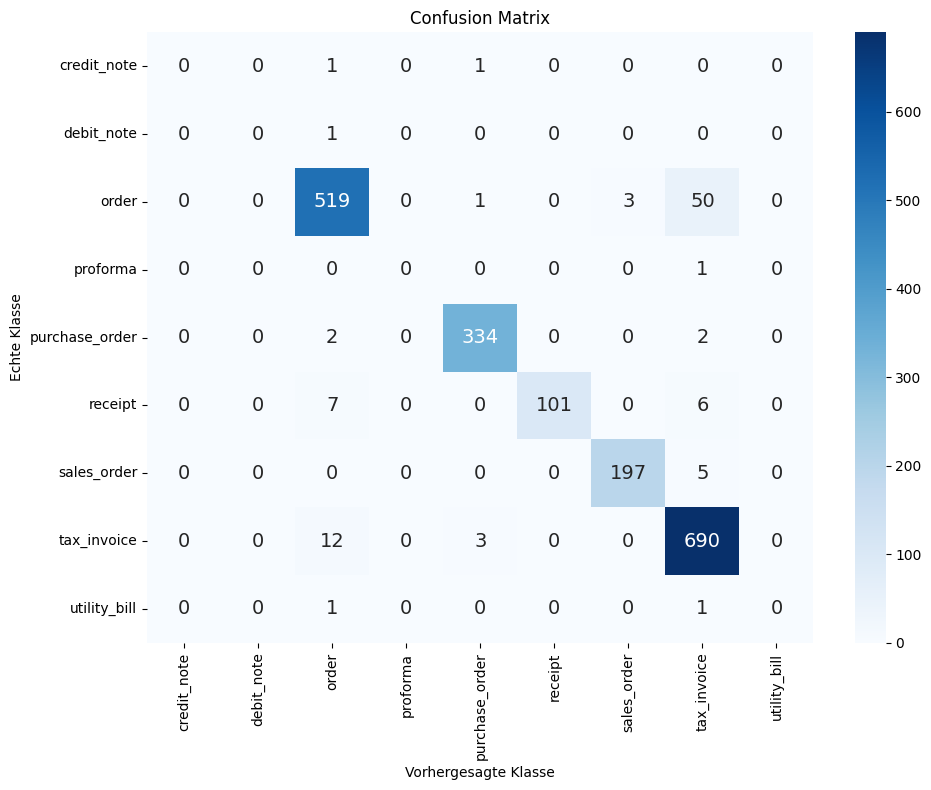

In [185]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_names, predicted_classes_names, labels=np.unique(y_test_names))

# Set the font size for the heatmap labels and annotations
font_size = 14  

# Display the confusion matrix as a heatmap with increased font size
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_names),
            yticklabels=np.unique(y_test_names), annot_kws={"size": font_size})
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Echte Klasse')
plt.title('Confusion Matrix')

plt.tight_layout()
# Save the figure with the specified font size
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/ImageClassification/VGG16/confusion_matrix' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.png')

plt.show()

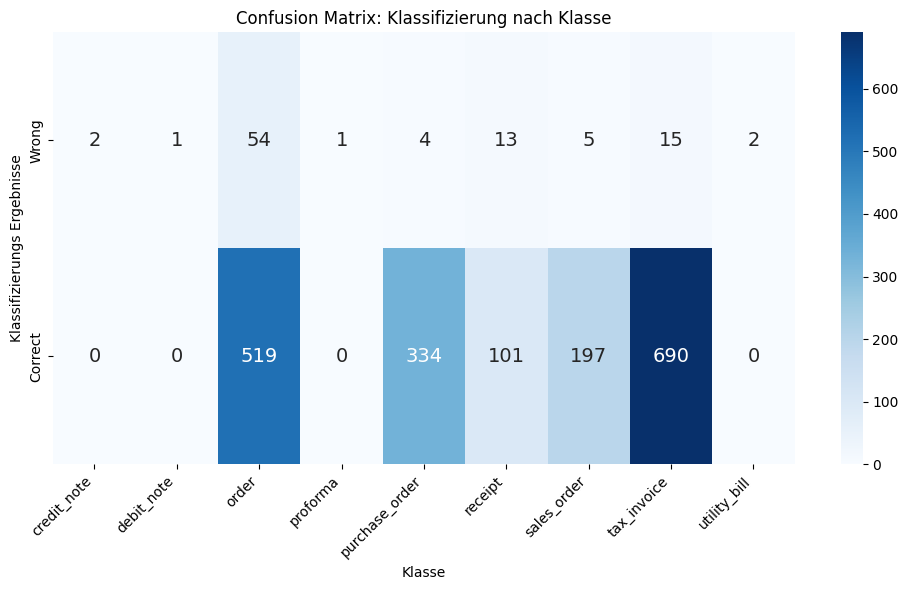

In [186]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define categories and data

categories = [
    "credit_note",
    "debit_note",
    "order",
    "proforma",
    "purchase_order",
    "receipt",
    "sales_order",
    "tax_invoice",
    "utility_bill"
]

wrong_counts = [
    false_pred.count("credit_note"),  # credit_note
    false_pred.count("debit_note"),  # debit_note
    false_pred.count("order"), # order
    false_pred.count("proforma"),  # proforma
    false_pred.count("purchase_order"),  # purchase_order
    false_pred.count("receipt"), # receipt
    false_pred.count("sales_order"),  # sales_order
    false_pred.count("tax_invoice"),  # tax_invoice
    false_pred.count("utility_bill")  # utility_bill
]

total_counts = [
    false_pred.count("credit_note") + true_pred.count("credit_note"),   # credit_note
    false_pred.count("debit_note") + true_pred.count("debit_note"),   # debit_note
    false_pred.count("order") + true_pred.count("order"), # order
    false_pred.count("proforma") + true_pred.count("proforma"),   # proforma
    false_pred.count("purchase_order") + true_pred.count("purchase_order"), # purchase_order
    false_pred.count("receipt") + true_pred.count("receipt"),  # receipt
    false_pred.count("sales_order") + true_pred.count("sales_order"), # sales_order
    false_pred.count("tax_invoice") + true_pred.count("tax_invoice"),  # tax_invoice
    false_pred.count("utility_bill") + true_pred.count("utility_bill")   # utility_bill
]
total_counts = np.array(total_counts)

# Calculate percentage of wrong classifications
wrong_percentages = wrong_counts / total_counts * 100

# Create a confusion matrix
confusion_matrix = np.vstack((wrong_counts, total_counts - wrong_counts))

font_size = 14  

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=categories, yticklabels=['Wrong', 'Correct'],
            annot_kws={"size": font_size})  # Set font size for annotations
plt.xlabel('Klasse')
plt.ylabel('Klassifizierungs Ergebnisse')
plt.title('Confusion Matrix: Klassifizierung nach Klasse')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/ImageClassification/VGG16/confusion_matrix2' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.png', bbox_inches="tight")
plt.show()

In [187]:
with open("/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/F1_Scores.pkl", "rb") as file:
    F1_Scores = pickle.load(file)
with open("/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/Precision.pkl", "rb") as file:
    Precsision = pickle.load(file)
with open("/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/Recall.pkl", "rb") as file:
    Recall = pickle.load(file)
with open("/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/ClassAccuracys.pkl", "rb") as file:
    ClassAccuracys = pickle.load(file)

In [188]:
from sklearn.metrics import precision_score,accuracy_score, f1_score, recall_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test_names, predicted_classes_names)

# Calculate precision
precision_scores = precision_score(y_test_names, predicted_classes_names, average=None)

# Calculate F1 score for each class
f1_scores = f1_score(y_test_names, predicted_classes_names, average=None)

# Calculate recall for each class
recall_scores = recall_score(y_test_names, predicted_classes_names, average=None)

# Print accuracy
print(f"Accuracy: {accuracy:.2f}")

# Print F1 score and recall for each class
for class_idx, (precision, f1, recall) in enumerate(zip(precision_scores, f1_scores, recall_scores)):
    print(f"Class {class_idx}:")
    print(f"Precision: {precision:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"Recall: {recall:.3f}")
    

Accuracy: 0.95
Class 0:
Precision: 0.000
F1 Score: 0.000
Recall: 0.000
Class 1:
Precision: 0.000
F1 Score: 0.000
Recall: 0.000
Class 2:
Precision: 0.956
F1 Score: 0.930
Recall: 0.906
Class 3:
Precision: 0.000
F1 Score: 0.000
Recall: 0.000
Class 4:
Precision: 0.985
F1 Score: 0.987
Recall: 0.988
Class 5:
Precision: 1.000
F1 Score: 0.940
Recall: 0.886
Class 6:
Precision: 0.985
F1 Score: 0.980
Recall: 0.975
Class 7:
Precision: 0.914
F1 Score: 0.945
Recall: 0.979
Class 8:
Precision: 0.000
F1 Score: 0.000
Recall: 0.000


/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [189]:
Precision['IncV3_Precision' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order)] = precision_scores
F1_Scores['IncV3_F1' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order)] = f1_scores
Recall['IncV3_Recall' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order)] = recall_scores
ClassAccuracys['IncV3_ClassAcc' + str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order)] = class_accuracies

In [190]:
with open("/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/F1_Scores.pkl", 'wb') as file:
    pickle.dump(F1_Scores, file)

with open("/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/Precision.pkl", 'wb') as file:
    pickle.dump(precision_scores, file)

with open("/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/Recall.pkl", 'wb') as file:
    pickle.dump(Recall, file)

with open("/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/ClassAccuracys.pkl", 'wb') as file:
    pickle.dump(ClassAccuracys, file)

<Figure size 1000x600 with 0 Axes>

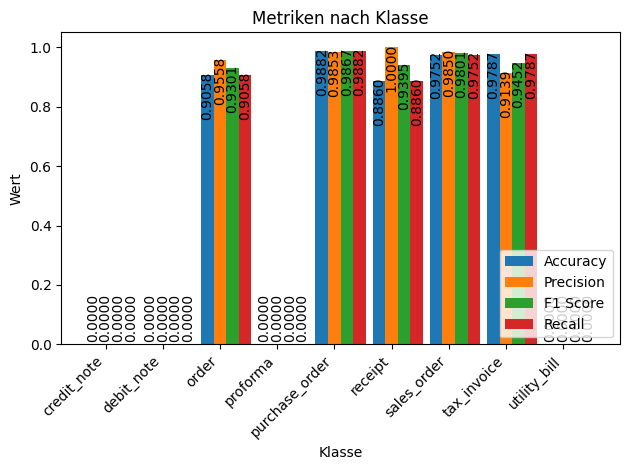

In [191]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

font = {'size': 10}
matplotlib.rc('font', **font)

# values for accuracy, F1 score, and recall for each class
precision_values = precision_scores
accuracy_values = class_accuracies
f1_score_values = f1_scores
recall_values = recall_scores

# Set the width of the bars (increase the bar width for wider bars)
bar_width = 0.22  # Adjust this value for wider bars

# Calculate the x-axis positions for each class
x = np.arange(len(categories))

plt.figure(figsize=(10, 6))

# Create subplots for accuracy, F1 score, and recall
fig, ax = plt.subplots()

# Create wider bars for each metric
bar_accuracy = ax.bar(x - bar_width, accuracy_values, width=bar_width, label='Accuracy')  # Adjusted x-coordinates
bar_precision = ax.bar(x, precision_values, width=bar_width, label='Precision')
bar_f1_score = ax.bar(x + bar_width, f1_score_values, width=bar_width, label='F1 Score')
bar_recall = ax.bar(x + 2*bar_width, recall_values, width=bar_width, label='Recall')  # Adjusted x-coordinates

y_ticks = np.arange(0, 1.1, 0.2)
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{tick:.1f}" for tick in y_ticks])

# Set the labels for x-axis and y-axis
ax.set_xlabel('Klasse')
ax.set_ylabel('Wert')
ax.set_title('Metriken nach Klasse')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha="right")

# Display numerical values inside the wider bars vertically and centered
for bars in [bar_precision, bar_accuracy, bar_f1_score, bar_recall]:
    for bar in bars:
        height = bar.get_height()
        bar_height = bar.get_height()
        if bar_height == 0:
            bar_height  = 0.16
            
        ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, bar_height - 0.07),
                    xytext=(0, 0), textcoords='offset points',
                    ha='center', va='center', rotation=90)  # Place text inside the bar vertically



# Move the legend to the bottom right
ax.legend(loc='lower right')

# Show the plot
plt.tight_layout()
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/ImageClassification/InceptionV3/metrics'+ str(name_layer) + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.png')
plt.show()


In [192]:
Precision

{'IncV3_Precision_all_layer_30epochs_10_5': array([1.        , 0.        , 0.98613518, 0.33333333, 1.        ,
        0.98245614, 1.        , 0.99431818, 1.        ]),
 'IncV3_Precision_all_layer_50epochs_10_5': array([0.5       , 0.        , 0.98448276, 0.        , 1.        ,
        1.        , 1.        , 0.99151344, 1.        ]),
 'IncV3_Precision_all_layer_100epochs_10_5': array([0.33333333, 1.        , 0.99304348, 1.        , 0.99704142,
        1.        , 1.        , 0.99291785, 1.        ]),
 'IncV3_Precision_added_layer_100epochs_10_5': array([0.        , 0.        , 0.95068027, 0.        , 0.99401198,
        1.        , 1.        , 0.96643357, 0.        ]),
 'IncV3_Precision_added_layer_50epochs_10_5': array([0.        , 0.        , 0.96491228, 0.        , 0.98813056,
        0.99065421, 1.        , 0.95192308, 0.        ]),
 'IncV3_Precision_added_layer_30epochs_10_5': array([0.        , 0.        , 0.9558011 , 0.        , 0.98525074,
        1.        , 0.985     , 0.91